# Correlation analysis between the Bitcoin currency and Twitter

This project consists of a correlation analysis between the Bitcoin currency and tweets. In order to define the positiveness of a tweet (if the course of the bitcoin will go up or down), we realise a sentiment analysis of each tweet using the VADER algorithm. Finally we try to find a correlation between the two and we will make some machine learning to make predictions.

This notebook was written using Python 3.6.

## Import the Python dependencies
For this project we need Pandas to manage all of our datasets.

You will need to run the following commands with pip to install the dependencies:

```
pip install VaderSentiment
pip install pandas
pip install tqdm
...
```

You can also run `pip install .` from the project's root folder to install all the requirements from the `requirements.txt` file.

In [31]:
import json
import pandas as pd
import io
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
import glob
from datetime import datetime

## Set the currency and the data files

In [32]:
# Define the currency
#CURRENCY = "zilliqa"
#CURRENCY_SYMBOL = "ZIL"
#CURRENCY = "nexo"
#CURRENCY_SYMBOL = "NEXO"
CURRENCY = "bitcoin"
CURRENCY_SYMBOL = "BTC"


CRYPTO_FOLDER = f"data/crypto/{CURRENCY_SYMBOL}"
TWITTER_FOLDER = f"data/twitter/{CURRENCY_SYMBOL}"

tweets_clean_file = f'{TWITTER_FOLDER}/{CURRENCY}_tweets_clean.csv'

## Load the datasets
We read the data generated from two other notebooks, TwitterExtraction and CryptoCurrencyExtraction. The data is stored in 2 CSV files. The first one contains around 430'000 tweets all related to the Bitcoin on a period of 10 days between the 10.05.2018 and the 20.05.2018. The second dataset contains the historical data of the exchange rate between Bitcoin and USD over the same period of time.

In [33]:
tweets = pd.read_csv(tweets_clean_file)

# Drop duplicate tweets
print('tweet shape before droping duplicates', tweets.shape)
duplicates_removed = tweets.shape[0]
tweets = tweets.drop_duplicates(subset=['ID'])
duplicates_removed -= tweets.shape[0]
print('tweet shape after droping duplicates', tweets.shape)
print('duplicates removed', duplicates_removed)

tweets.head(5)

tweet shape before droping duplicates (428973, 7)
tweet shape after droping duplicates (423849, 7)
duplicates removed 5124


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt
0,998140768622596097,RT : Check out our new bounty program on Bitco...,Neaj Morshed,88,2080,0,Sun May 20 09:57:58 +0000 2018
1,998140767016173569,RT : GIN CASH early backers bounty distributio...,Ирина Абрамова,0,4125,0,Sun May 20 09:57:58 +0000 2018
2,998140757872529408,"RT : Here’s a sneak peak, the title:‘My Tweet ...",julia,10,35,0,Sun May 20 09:57:55 +0000 2018
3,998140749114888192,RT : GIN CASH early backers bounty distributio...,Tan Booking,186,4125,0,Sun May 20 09:57:53 +0000 2018
4,998140746493505536,RT : PO8 CMO Raul Vasquez and ICON Co-Founder...,gospetig,23,469,0,Sun May 20 09:57:53 +0000 2018


In [34]:
crypto_files = glob.glob(f"{CRYPTO_FOLDER}/*.csv")
dfs = []
for file in crypto_files:
    dfs.append(pd.read_csv(file))
crypto_usd = pd.concat(dfs)
crypto_usd = crypto_usd.sort_values(by=['time'])

# Drop duplicates
print('bitcoin shape before droping duplicates', crypto_usd.shape)
duplicates_removed = crypto_usd.shape[0]
crypto_usd = crypto_usd.drop_duplicates(subset=['time'])
print('bitcoin shape after droping duplicates', crypto_usd.shape)
duplicates_removed -= crypto_usd.shape[0]
print('duplicates removed', duplicates_removed)
crypto_usd.head(5)

bitcoin shape before droping duplicates (20317, 5)
bitcoin shape after droping duplicates (20302, 5)
duplicates removed 15


,close,high,low,open,time
0,8737.87,8747.28,8737.63,8745.27,1526032500
1,8745.14,8745.14,8737.76,8738.79,1526032560
2,8748.48,8753.09,8744.79,8745.14,1526032620
3,8746.25,8748.76,8742.89,8748.48,1526032680
4,8753.83,8753.86,8743.80,8746.25,1526032740


## Sentiment analysis

### VADER
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

VADER takes into account 
- negations and contractions (not good, wasn’t good)
- Ponctuation (good!!!), CAPS, emotes :), emojis 
- Intensificators (very, kind of), acronyms ‘lol’
- Scores between -1.0 (negative) and 1.0 (positive)

We will use this sentiment analysis of the tweets to calculate a score that will represent the importance of each tweet.

In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(tweets['Text'])):
    vs = analyzer.polarity_scores(s)
    compound.append(vs["compound"])
tweets["compound"] = compound
tweets.head(5)

100%|██████████| 423849/423849 [01:43<00:00, 4088.60it/s]


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound
0,998140768622596097,RT : Check out our new bounty program on Bitco...,Neaj Morshed,88,2080,0,Sun May 20 09:57:58 +0000 2018,0.4767
1,998140767016173569,RT : GIN CASH early backers bounty distributio...,Ирина Абрамова,0,4125,0,Sun May 20 09:57:58 +0000 2018,0.0000
2,998140757872529408,"RT : Here’s a sneak peak, the title:‘My Tweet ...",julia,10,35,0,Sun May 20 09:57:55 +0000 2018,0.2023
3,998140749114888192,RT : GIN CASH early backers bounty distributio...,Tan Booking,186,4125,0,Sun May 20 09:57:53 +0000 2018,0.0000
4,998140746493505536,RT : PO8 CMO Raul Vasquez and ICON Co-Founder...,gospetig,23,469,0,Sun May 20 09:57:53 +0000 2018,0.0000


### Calculate a score for each tweet
To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.

The compound column represents the sentiment of the tweets and its value is between -1 and 1.

We also use the number of retweets, the number of likes, and the number of users that follow the tweet's author.

In [36]:
scores = []
for i, s in tqdm(tweets.iterrows(), total=tweets.shape[0]):
    scores.append(s["compound"] * ((s["UserFollowerCount"]+1)) * ((s["Likes"]+1)))
tweets["Scores"] = scores
tweets.head(5)

100%|██████████| 423849/423849 [00:32<00:00, 12851.05it/s]


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound,Scores
0,998140768622596097,RT : Check out our new bounty program on Bitco...,Neaj Morshed,88,2080,0,Sun May 20 09:57:58 +0000 2018,0.4767,42.4263
1,998140767016173569,RT : GIN CASH early backers bounty distributio...,Ирина Абрамова,0,4125,0,Sun May 20 09:57:58 +0000 2018,0.0000,0.0000
2,998140757872529408,"RT : Here’s a sneak peak, the title:‘My Tweet ...",julia,10,35,0,Sun May 20 09:57:55 +0000 2018,0.2023,2.2253
3,998140749114888192,RT : GIN CASH early backers bounty distributio...,Tan Booking,186,4125,0,Sun May 20 09:57:53 +0000 2018,0.0000,0.0000
4,998140746493505536,RT : PO8 CMO Raul Vasquez and ICON Co-Founder...,gospetig,23,469,0,Sun May 20 09:57:53 +0000 2018,0.0000,0.0000


In [37]:
tweets.tail(100)

,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound,Scores
428872,994581721910775809,RT : Check out for artwork engineered to gener...,LynxArtCollection.com,1473,3,0,Thu May 10 14:15:35 +0000 2018,-0.2263,-333.5662
428873,994581707176202240,RT : e-Chat Team Shares its Experience at Nort...,Cryachko Eugeny,244,102,0,Thu May 10 14:15:32 +0000 2018,0.2960,72.5200
428874,994581647675875328,Free 5 Legitcoin token until 24 February! In M...,Sarah,203,1,0,Thu May 10 14:15:17 +0000 2018,0.5972,121.8288
428875,994581572056764416,RT : AIRDROP-Claim your share -100$ AFTK TOKEN...,Jevgeni,112,419,0,Thu May 10 14:14:59 +0000 2018,0.6597,74.5461
428876,994581557775134720,RT : jetcoin now listed on mercatox exchange!...,matthew adams,556,1,0,Thu May 10 14:14:56 +0000 2018,0.6467,360.2119
428877,994581515068739584,Clients are forcing large companies to start w...,Coinsland,68,0,5,Thu May 10 14:14:46 +0000 2018,0.0000,0.0000
428878,994581493564534789,RT : ThursdayThoughtsRemember to join us today...,Johnnyboy Crypto,774,10,0,Thu May 10 14:14:41 +0000 2018,0.4184,324.2600
428879,994581311347134465,RT : Homelend pre sale is ON!! Get 20% bonus d...,wuking,7778,331,0,Thu May 10 14:13:57 +0000 2018,0.6229,4845.5391
428880,994581285111771136,Hourly Money Making Machine - Bitcoin Litecoin...,Healthy&Beauty,1584,0,0,Thu May 10 14:13:51 +0000 2018,0.0000,0.0000
428881,994581269173456896,RT : Bitcoin $BTC was never in a long-term bea...,Vogue Blackheart,276,14,0,Thu May 10 14:13:47 +0000 2018,0.0000,0.0000


## Group by and sum by 5 minutes

In [38]:
tweets['CreatedAt'] = pd.to_datetime(tweets['CreatedAt'])
tweets.index = tweets['CreatedAt']

tweets_grouped = tweets.groupby(pd.TimeGrouper('1h'))['Scores'].sum()

crypto_usd['time'] = pd.to_datetime(crypto_usd['time'], unit='s')
crypto_usd.index = crypto_usd['time']

crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('1h'))['close'].mean()

### Plotting the scores
We calculate the mean of each tweets grouped by hour and then we plot it.

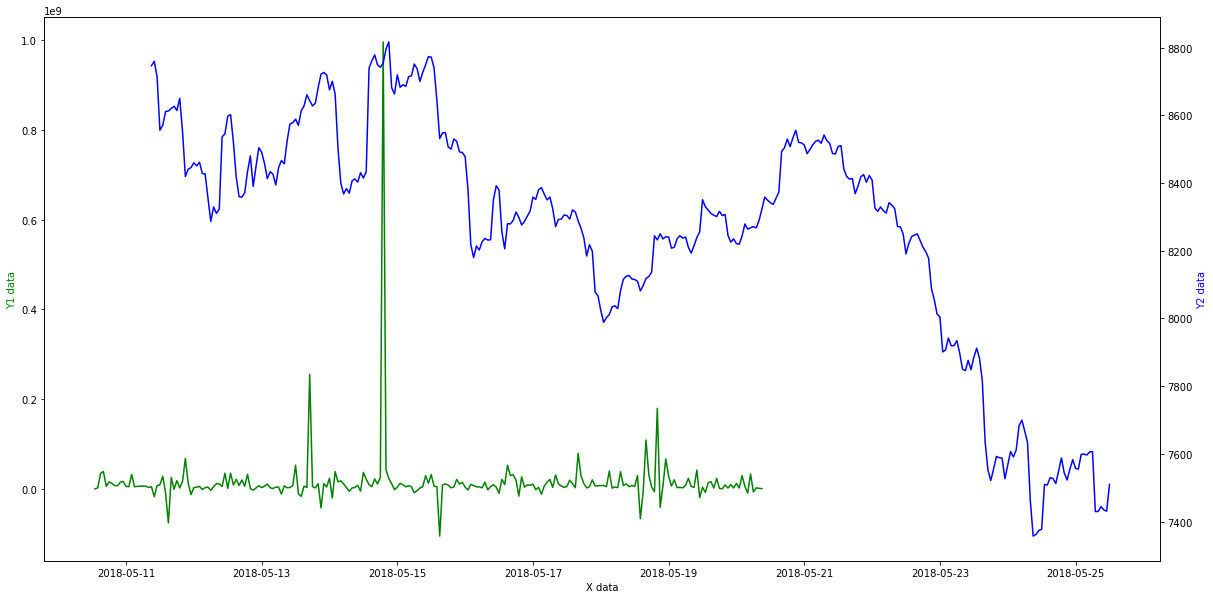

In [39]:
#
#plt.plot_date(tweets_grouped.index, tweets_grouped, ls='-', marker='o')
#plt.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, ls='-', marker='o')
#plt.show()

fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')
plt.show()

## Correlation analysis
Here we make the correlation analysis between BTC/USD currency derivative and the tweets scores derivative.

We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

This Stackoverflow answer gives very useful details about correlating with time series.
https://stackoverflow.com/questions/6467832/how-to-get-the-correlation-between-two-timeseries-using-pandas

In [40]:
tweets_grouped.corr(crypto_usd_grouped)

0.097433800660714429

### Derivative and offset
We will need a bit more complicated correlation analysis here as we need to correlate the derivative of both series and we will need to offset each serie from the other because the change increase in the Bitcoin currency should occure a few moments after the tweets. The task here is to find a good offset.

In [41]:
#Derivative and normalisation???

#Offset

#Correlation